# The SBI Workflow

In [1]:
from math import pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import ones, zeros, eye, as_tensor, tensor, float32
from torch.distributions import MultivariateNormal, Exponential

from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform, MultipleIndependent

from paper.colors import colors

## Ball Throw Example

In this notebook we go through a full SBI workflow, using the ball throw simulator as
our guiding example throughout. The ball throw example models the trajectory of a ball,
$(x(t),y(t))$, after it is initially thrown from $(x(0)=0,y(0)=0)$ at an angle of
$\theta$ to the ground and initial speed $v$. As well as the throwing parameters
$\theta,v$, the trajectory of the ball is also affected by the gravitational
acceleration $g$, the wind strength $W$, and the friction coefficient $\mu$.

We can describe the trajectory of the ball using the ordinary differential equation:

\begin{aligned}
\frac{d^2x}{dt^2} &= W - \mu \frac{dx}{dt} \\
\frac{d^2y}{dt^2} &= -g - \mu \frac{dy}{dt}
\end{aligned}

with initial conditions:
$
x(0) = 0, \, y(0) = 0, \quad \frac{dx}{dt}(0) = v \cos\theta, \, \frac{dy}{dt}(0) = v \sin\theta
$

This model is simulated using the code below:

In [2]:
dt = 0.5 # Time step for the simulation.

_ = np.random.seed(42)  # For reproducibility


def simulate(angle, strength, gravity, wind, friction, noisy = False):
    """
    Return trajectory of a ball thrown at a given angle and strength, with a given
    gravity, wind and friction.

    Arguments:
    angle: float, angle in degrees at which the ball is thrown
    strength: float, initial speed of the ball
    gravity: float, gravitational acceleration
    wind: float, wind speed in the x direction
    friction: float, friction coefficient

    Returns:
    xs: list of floats, x positions of the ball at each time step (maximum 10,000 steps)
    ys: list of floats, y positions of the ball at each time step (maximum 10,000 steps)
    
    """
    #Initialize position
    xs = [0.0]
    ys = [0.0]

    angle = angle / 180 * pi #We assume angle is given in degrees, and convert to radians.

    dx = np.cos(angle) * strength
    dy = np.sqrt(strength**2 - dx**2)
    

    # We simulate until the ball hits the ground, or until we reach a maximum number of
    # steps. This maximum number of steps is set to 10,000, which should be more than
    # enough for the ball to hit the ground for all parameter values we simulate.
    for i in range(10_000): 
        x, y, dx, dy = step(xs[-1], ys[-1], dx, dy, dt, gravity, wind, friction)
        xs.append(x)
        ys.append(y)
        if i > 1 and ys[-1] < 0:
            break

    # We optionally add some observation noise to the trajectory.
    if noisy:
        xs = np.random.randn(len(xs)) * 0.01 + np.array(xs)
        ys = np.random.randn(len(ys)) * 0.01 + np.array(ys)
    return xs, ys

def step(x, y, dx, dy, dt, gravity, wind, friction):
    """
    Simulate one step of the ball's trajectory.
    Arguments:
    x: float, current x position of the ball
    y: float, current y position of the ball
    dx: float, current x velocity of the ball
    dy: float, current y velocity of the ball
    dt: float, time step for the simulation
    See simulate() for the meaning of the other arguments.

    Returns:
    x: float, new x position of the ball
    y: float, new y position of the ball
    dx: float, new x velocity of the ball
    dy: float, new y velocity of the ball
    
    """
    friction_x = friction * dx
    friction_y = friction * dy

    ddy = -gravity - friction_y
    dy += ddy * dt

    ddx = wind - friction_x
    dx += ddx * dt

    return x + dx * dt, y + dy * dt, dx, dy


Let's simulate and visualize some trajectories

(0.0, 2.2881871009467827)

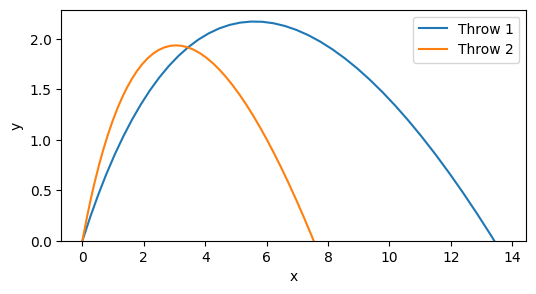

In [3]:
angle1 = 45
strength1 = 0.7
gravity1 = 0.05
wind1 = 0.03
friction1 = 0.01
# We turn off observation noise for this illustation.
xs1, ys1 = simulate(angle1, strength1, gravity1, wind1, friction1,noisy = False)

angle2 = 60
strength2 = 0.5
gravity2 = 0.04
wind2 = 0.02
friction2 = 0.02
xs2, ys2 = simulate(angle2, strength2, gravity2, wind2, friction2,noisy = False)


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(xs1,ys1, label = "Throw 1")
_ = ax.plot(xs2,ys2, label = "Throw 2")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.legend()
ax.set_ylim(bottom=0)



# Summary Statistics

Instead of learning the posterior from the entire trajectory $(x(t),y(t))$, which is a
high-dimensional matrix, we can define statistics which summarize the trajectory into
some low-dimensional vector containing values of interest. In this case, we use the 
throw distance, i.e. the value of $x$ where the ball landed $(y=0)$. We also use the 
highest point reached by the ball, $y_{\text{max}}$.


In [4]:
def summary_stats(xs, ys):
    frac = 1 - (ys[-1] / (ys[-1] - ys[-2]))
    return np.array([frac * (xs[-1] - xs[-2]) + xs[-2],np.max(ys)])

# Defining the prior distribution

In principle, any of the parameters $[\theta, v, g, W, \mu]$ could be unknown. If all 
parameters are unknown, we would need to infer a 5-dimensional posterior distribution.
In this notebook, we assume the setting of the paper, where $v,g,\mu$ are all known,
fixed constants. The wind strength $W$ is unknown, but rather a source of noise in the
simulator. We wish to infer the unknown throw angle $\theta$.

In [5]:
prior_angle = MultivariateNormal(35 * torch.ones((1,)), 15**2 * torch.eye(1))
latent_wind_distribution = Exponential(200.0 * torch.ones((1,)))
fixed_strength = 0.7
fixed_gravity = 0.05
fixed_friction = 0.1



## Sampling from the prior, and simulating

In the code block below we sample from the prior of the throwing angle, and simulate the 
throw trajectories assuming the fixed parameters, and a random wind strength drawn from 
the latent distribution.

In [6]:
num_simulations = 10_000

# Sample angles from prior
theta = prior_angle.sample((num_simulations,))
# Simulate trajectories
sum_stats = []
for t in theta:
    w = latent_wind_distribution.sample((1,))
    trace = simulate(angle=t.item(),
                     strength=fixed_strength,
                     gravity=fixed_gravity,
                     wind=w.item(),
                     friction=fixed_friction,
                     noisy=True)
    ss = summary_stats(trace[0], trace[1])
    sum_stats.append(ss)
sum_stats = np.array(sum_stats)
sum_stats = torch.as_tensor(sum_stats, dtype=float32)

## Training the Density Estimator

Now that we have the dataset of simulations, we can define a neural network that will
be trained by the data. In this case, we opt for Neural Posterior Estimation (NPE), 
therefore estimating the posterior distribution directly.

In [7]:
_ = torch.manual_seed(0)

#The density estimator is the neural network we are training.
#We use a neural spline flow (nsf) here, but other choices exist.
inference = NPE(prior=prior_angle, density_estimator="nsf")
_ = inference.append_simulations(theta,sum_stats).train(max_num_epochs=200)

 Neural network successfully converged after 77 epochs.

## Obtain an "Observation"

Here, we create another simulation, separate to the ones we used in training. This 
simulation stands in for our "observation" in this tutorial, as opposed to data from a
real "ball throw" experiment. This also allows us to measure the performance of our
inference, as we can test whether the true throwing angle we generated this observation
with falls within the support of the posterior distribution.

Note here that the training workflow (above) is completely independent from this 
"observation" - we can use any observation here! The fact that once the posterior is 
trained, it can be applied to any observation without any further training, is known as
**amortized inference**.



(0.0, 0.6654077888409942)

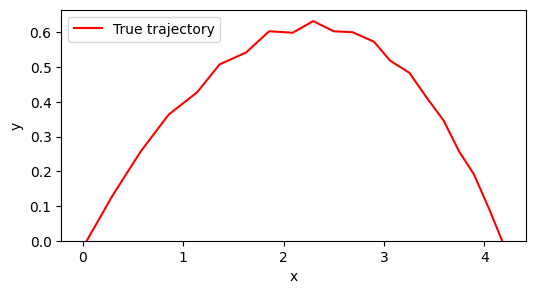

In [8]:
posterior = inference.build_posterior()


true_angle = 27.0
true_wind = 0.01

true_x,true_y = simulate(true_angle, fixed_strength, fixed_gravity, true_wind, fixed_friction, noisy=True)
true_ss = summary_stats(true_x, true_y)
true_ss = torch.as_tensor(true_ss, dtype=float32)

#Visualize true trajectory
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(true_x, true_y, label="True trajectory", color="red")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.legend()
ax.set_ylim(bottom=0)

## Evaluate posterior at observation

Let's sample from the posterior distribution and visualize it!

In [9]:
posterior = inference.build_posterior()
posterior.set_default_x(true_ss)

#sample from the posterior
posterior_samples = posterior.sample((1000,))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

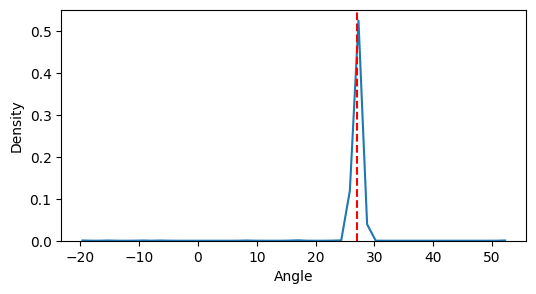

In [10]:
# Calculate kde and plot
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(1, 1, figsize=(6,3))
density = gaussian_kde(posterior_samples.squeeze())
thetas = np.linspace(posterior_samples.min(),posterior_samples.max(), 50)
probs = density(thetas)
_ = ax.plot(thetas, probs)
_ = ax.axvline(true_angle, color="red", linestyle="--", label="True angle")
_ = ax.set_xlabel("Angle")
_ = ax.set_ylabel("Density")
_ = ax.set_ylim(bottom=0)



## Evaluating the Posterior Distribution

We now have an amortized posterior estimator. We also see in the plot above that for
a given observation, the posterior seems to correctly identify the true parameter used
to generate that observation. However, by itself, this is not sufficient to conclude
that our inference workflow worked. We now explore two further ways we can check whether
we have converged to a good posterior estimator. First, we use Posterior Predictive
Checks (PPC), and we follow this with Simulation-Based Calibration (SBC).

## Posterior Predictive Checks

Given a posterior distribution from some observation, we can simulate samples from the
posterior, to obtain predictions for the observation. This is known as the posterior
predictive. Intuitively, samples from the posterior predictive should closely match
the observation.

In [11]:
# sample from the posterior and simulate trajectories

num_posterior_predictive_samples = 10
samples = posterior.sample((num_posterior_predictive_samples,), x=true_ss)
ppc_traces = [] #trajectories of posterior predictive samples
ppc_ss = [] #summary statistics of posterior predictive samples
for t in samples:
    w = latent_wind_distribution.sample((1,))
    trace = simulate(angle=t.item(),
                     strength=fixed_strength,
                     gravity=fixed_gravity,
                     wind=w.item(),
                     friction=fixed_friction,
                     noisy=True)
    ss = summary_stats(trace[0], trace[1])
    ppc_traces.append(trace)
    ppc_ss.append(ss)


ppc_ss = np.array(ppc_ss)


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

(0.0, 0.6802218452323022)

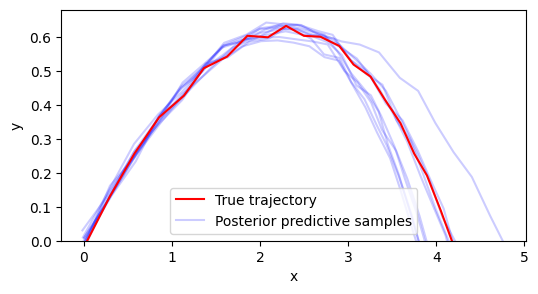

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(true_x, true_y, c="red",zorder=2)
for i in range(num_posterior_predictive_samples):
    _ = ax.plot(ppc_traces[i][0], ppc_traces[i][1], c="b", alpha=0.2,zorder=1)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.legend(["True trajectory", "Posterior predictive samples"])
ax.set_ylim(bottom=0)

In [13]:
# We also calculate the average RMSE of the summary statistics of the posterior 
# predictive samples with respect to the true summary statistics.
rmses = np.sqrt(np.mean((ppc_ss - true_ss.numpy())**2, axis=1))
rmse = np.mean(rmses)
print(f"RMSE of posterior predictive samples: {rmse}")

RMSE of posterior predictive samples: 0.17521095078818597


## Simulation Based Calibration

Plotting the posterior for a given observation, or calculating the posterior predictive
check errors for given observations, gives us a quantification of the quality of the 
posterior at a given observation. For many problems, we want to evaluate the posterior
**globally** - i.e., how well does the posterior estimator do on average across all
possible observations? For this, we use SBC. For this, we evaluate the posterior
distribution for **many** observations - hence, this is typically only feasible for
**amortized** posterior estimators where the posterior can be evaluated quickly for
new observations.



In [14]:
# We generate many possible observations. 
# First, we sample the prior

num_sbc_samples = 200

prior_samples = prior_angle.sample((num_sbc_samples,))

# For each prior sample, we generate an observation
sbc_ss = [] #summary statistics of sbc simulations
for t in prior_samples:
    w = latent_wind_distribution.sample((1,))
    trace = simulate(angle=t.item(),
                     strength=fixed_strength,
                     gravity=fixed_gravity,
                     wind=w.item(),
                     friction=fixed_friction,
                     noisy=True)
    ss = summary_stats(trace[0], trace[1])
    sbc_ss.append(ss)

sbc_ss = np.array(sbc_ss)
sbc_ss = torch.as_tensor(sbc_ss, dtype=float32)

## Choice of SBC reducing function

In principle, there are many different ways to perform simulation-based calibration, 
corresponding to different **reducing functions** $f(\theta,x)\in\mathbb{R}$.

One common choice, which we use here, is to use the posterior estimator's density as the
reducing funciton.

In [15]:
from sbi.diagnostics import run_sbc

num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    prior_samples,
    sbc_ss,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x), 
    num_posterior_samples=num_posterior_samples,
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

## How to interpret SBC results

In this case that we use the posterior density as the reducing function, the SBC check 
returns the **expected coverage** of the posterior. This corresponds to the fraction of 
prior samples that are within a certain confidence interval of the corresponding 
posterior distribution. In a perfect posterior, the confidence intervals and coverage
fractions match - for example, 20% of prior samples should fall within the top 20% 
confidence region of their respective posteriors. In this case, plotting the confidence
level $x%$ against the empirical coverage $y%$ should yield the line $y=x$.

In practice, if we get something above this line, we say the posterior is 
**underconfident** - the posterior is too broad and thus covers too many of the prior
samples. If the empirical coverage is below this line, we say the posterior is 
**overconfident** - the posterior is too narrow, and so does not cover enough of the
prior samples.

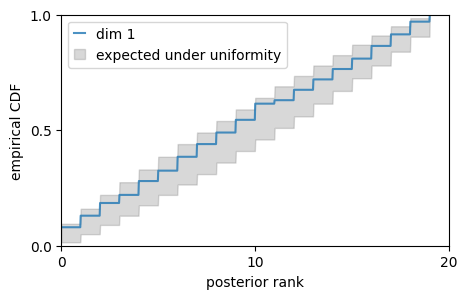

In [16]:
from sbi.analysis.plot import sbc_rank_plot

fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(5, 3),
)